In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import datetime
from lifetimes import GammaGammaFitter,BetaGeoFitter
from lifetimes.plotting import plot_period_transactions

from sqlalchemy import create_engine

In [3]:
pd.set_option("display.max_columns" , None)
pd.set_option("display.float_format" , lambda x : "%.3f" % x)
pd.set_option("display.width",200)

In [4]:
def outlier_thresholds(dataframe,col_name, q1 = 0.01, q3 = 0.99):
    quantile1 = dataframe[col_name].quantile(q1)
    quantile3 = dataframe[col_name].quantile(q3)
    interquantile = quantile3 - quantile1
    up_limit = quantile3 + 1.5*interquantile
    low_limit = quantile1 - 1.5*interquantile
    return up_limit,low_limit

In [5]:
def replace_with_threshols(dataframe, col_name ,q1=0.01, q3 = 0.99):
    up_limit, low_limit = outlier_thresholds(dataframe, col_name, q1 , q3)
    dataframe.loc[ (dataframe[col_name] > up_limit)  , col_name] = up_limit
    dataframe.loc[ (dataframe[col_name] < low_limit),  col_name] = low_limit

In [6]:
path= "/Users/gokhanersoz/Desktop/VBO_Dataset/online_retail_II.xlsx"

In [7]:
online_retail = pd.read_excel(path, sheet_name = "Year 2010-2011")

In [8]:
df = online_retail.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom


In [9]:
###########################
# EXTRA : Reading Data from Database
###########################
#host    : db.github.rocks
#port    : 3306
#user    : synan_dsmlbc_group_3_admin
#pass    : iamthedatascientist*****!
#database: synan_dsmlbc_group_3

In [10]:
creds = {'user': 'synan_dsmlbc_group_3_admin',
         'passwd': 'iamthedatascientist*****!',
         'host': 'db.github.rocks',
         'port': 3306,
         'db': 'synan_dsmlbc_group_3'}

In [11]:
# MySQL connection string
# pip install mysql-connector-python-rf

connstr = 'mysql+mysqlconnector://{user}:{passwd}@{host}:{port}/{db}'
conn = create_engine(connstr.format(**creds))

In [12]:
pd.read_sql_query("show databases",conn)

,Database
0,information_schema
1,synan_dsmlbc_group_3


In [13]:
pd.read_sql_query("show tables", conn).head()

,Tables_in_synan_dsmlbc_group_3
0,CLTV_Prediction_Tugce_Ljungholm
1,cagatay_tuylu_cltv_final
2,cltv-prediction-selime
3,cltv_burak_aslan
4,cltv_prediction


In [14]:
retail_mysql_df = pd.read_sql_query("select * from online_retail_2010_2011", conn)
type(retail_mysql_df)

pandas.core.frame.DataFrame

In [15]:
retail_mysql_df.dtypes

id                      int64
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
unix                    int64
dtype: object

In [17]:
retail_mysql_df.head()

,id,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,unix
0,1,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,1291191960
1,2,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,1291191960
2,3,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,1291191960
3,4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,1291191960
4,5,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,1291191960


In [18]:
retail_mysql_df.iloc[:,1:-1].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom


In [19]:
# Let's get to our main topic.

# We examine with a describe outlier observations.
# With Quantity, Price variable has "-" values, we need to overcome them...

In [20]:
print("DataFrame Shape : {}".format(df.shape))

DataFrame Shape : (541910, 8)


In [21]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [22]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom


In [23]:
df.describe([0.01,0.99]).T

,count,mean,std,min,1%,50%,99%,max
Quantity,541910.000,9.552,218.081,-80995.000,-2.000,3.000,100.000,80995.000
Price,541910.000,4.611,96.760,-11062.060,0.190,2.080,18.000,38970.000
Customer ID,406830.000,15287.684,1713.603,12346.000,12415.000,15152.000,18212.000,18287.000


In [24]:
# Let's see how many unique countries there are...

country = df["Country"].value_counts()
country = pd.DataFrame(country)
country.columns = ["Country Values"]
country.head()

,Country Values
United Kingdom,495478
Germany,9495
France,8558
EIRE,8196
Spain,2533


In [25]:
# I only shot United Kingdom since we will make 6-month CLTV prediction for UK customers....

df_uk = df[df["Country"] == "United Kingdom"]
print("DataFrame Shape : {}".format(df_uk.shape))

DataFrame Shape : (495478, 8)


In [26]:
na_values = df_uk.isnull().sum()
na_values = na_values[na_values > 0]
na_values = pd.DataFrame(na_values, columns = ["NA_Values"])
na_values

,NA_Values
Description,1454
Customer ID,133600


In [27]:
# Here we see outliers for the variables Quantity and Price....
# Before using replace_with_thresholds with outlier_thresholds, I make a description and review
# Since the Min values of the Quantity and Price variables are "-" here, we need to get rid of them...

df_uk.describe([.01,.99]).T

,count,mean,std,min,1%,50%,99%,max
Quantity,495478.000,8.605,227.589,-80995.000,-2.000,3.000,100.000,80995.000
Price,495478.000,4.532,99.315,-11062.060,0.190,2.100,16.950,38970.000
Customer ID,361878.000,15547.871,1594.403,12346.000,12748.000,15514.000,18223.000,18287.000


In [28]:
df_uk.dropna(axis = 0 , inplace = True)

In [29]:
df_uk = df_uk[~df_uk["Invoice"].str.contains("C", na = False)]
df_uk = df_uk[df_uk["Quantity"] > 0 ]
df_uk.describe([.01, .99]).T

,count,mean,std,min,1%,50%,99%,max
Quantity,354345.000,12.049,190.428,1.000,1.000,4.000,100.000,80995.000
Price,354345.000,2.964,17.862,0.000,0.210,1.950,12.750,8142.750
Customer ID,354345.000,15552.436,1594.546,12346.000,12748.000,15522.000,18223.000,18287.000


In [30]:
num_cols = [col for col in df_uk.columns if df_uk[col].dtype != "object"]
for col in ["InvoiceDate","Customer ID"]:
    num_cols.remove(col)
num_cols

['Quantity', 'Price']

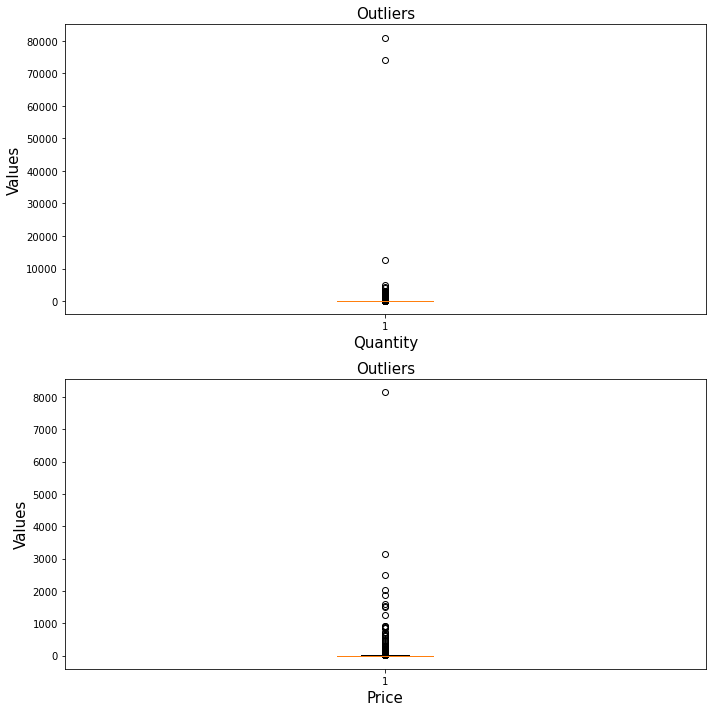

In [31]:
def box_plot(dataframe, num_cols):
    
    plt.figure(figsize = (10,10))
    num = len(num_cols)
    i=1
    size = 15
    
    for col in num_cols:
        plt.subplot(num , 1, i)
        plt.boxplot(dataframe[col])
        plt.xlabel(col , fontsize = size)
        plt.ylabel("Values" , fontsize = size)
        plt.title("Outliers" , fontsize = size)
        i+=1

    plt.tight_layout()
    plt.show()



box_plot(df_uk, num_cols);

In [32]:
df_uk.describe([.01,.99]).T

,count,mean,std,min,1%,50%,99%,max
Quantity,354345.000,12.049,190.428,1.000,1.000,4.000,100.000,80995.000
Price,354345.000,2.964,17.862,0.000,0.210,1.950,12.750,8142.750
Customer ID,354345.000,15552.436,1594.546,12346.000,12748.000,15522.000,18223.000,18287.000


In [33]:
# Outlier values disappear here.
# Quantity max = 80995 now max = 248.5
# Price max = 8142,750 while now max = 31.56

replace_with_threshols(df_uk ,"Quantity")
replace_with_threshols(df_uk ,"Price")
df_uk.describe([.01, .99]).T

,count,mean,std,min,1%,50%,99%,max
Quantity,354345.000,10.677,22.076,1.000,1.000,4.000,100.000,248.500
Price,354345.000,2.815,2.921,0.000,0.210,1.950,12.750,31.560
Customer ID,354345.000,15552.436,1594.546,12346.000,12748.000,15522.000,18223.000,18287.000


In [34]:
df_uk.InvoiceDate.max()

Timestamp('2011-12-09 12:49:00')

In [35]:
# We put two days on it...
today_date = datetime.datetime(2011,12,11) 
today_date

datetime.datetime(2011, 12, 11, 0, 0)

In [36]:
df_uk["TotalPrice"] = df_uk["Quantity"] * df_uk["Price"]
df_uk.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.000,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300
1,536365,71053,WHITE METAL LANTERN,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.000,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340


In [37]:
df_uk.Country.unique()

array(['United Kingdom'], dtype=object)

In [38]:
###########################
# Preparation of Lifetime Data Structure
###########################

## recency: The elapsed time since the last purchase. Weekly. 
##(according to analysis day on cltv_df, user specific here)

# T: The age of the customer. Weekly. (how long before the analysis date the first purchase was made)
# frequency: total number of repeat purchases (frequency>1)
# monetary_value: average earnings per purchase

In [39]:
cltv_df = \
df_uk.groupby("Customer ID").agg({"InvoiceDate" : 
                                  [lambda InvoiceDate : (InvoiceDate.max()-InvoiceDate.min()).days,
                                   lambda InvoiceDate : (today_date-InvoiceDate.min()).days],
                                 
                                 "Invoice" : lambda Invoice : Invoice.nunique(),
                                  "TotalPrice" : lambda TotalPrice : TotalPrice.sum()
                                 
                                 })

In [40]:
cltv_df.head()

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.000             0        326        1    258.440
12747.000           366        370       11   4196.010
12748.000           372        374      210  32303.910
12749.000           209        214        5   4072.440
12820.000           323        327        4    942.340

In [41]:
# # Here, let's download the first columns and fix the naming...
cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns

Index(['<lambda_0>', '<lambda_1>', '<lambda>', '<lambda>'], dtype='object')

In [42]:
# For Rfm print("Recency : ", (today_date - test.InvoiceDate.max()).days)

values = 12747.000

test = df_uk[df_uk["Customer ID"] == values]
print(f"Values : {values}")

print("Recency : ",(test.InvoiceDate.max() - test.InvoiceDate.min()).days)
print("T : ", (today_date - test.InvoiceDate.min()).days)

print("Frequence : " , (test.Invoice.nunique()))
print("Monetary : " , (test.TotalPrice.sum()))

Values : 12747.0
Recency :  366
T :  370
Frequence :  11
Monetary :  4196.009999999999


In [43]:
cltv_df.columns = ["Recency" , "T", "Frequence", "Monetary"]
cltv_df.head()

,Recency,T,Frequence,Monetary
Customer ID,,,,
12346.000,0,326,1,258.440
12747.000,366,370,11,4196.010
12748.000,372,374,210,32303.910
12749.000,209,214,5,4072.440
12820.000,323,327,4,942.340


In [44]:
# Here we need to update the monetary value as the average earnings per transaction
cltv_df["Monetary"] = cltv_df["Monetary"] / cltv_df["Frequence"]
cltv_df.head()

,Recency,T,Frequence,Monetary
Customer ID,,,,
12346.000,0,326,1,258.440
12747.000,366,370,11,381.455
12748.000,372,374,210,153.828
12749.000,209,214,5,814.488
12820.000,323,327,4,235.585


In [45]:
cltv_df.describe([.01, .99]).T

,count,mean,std,min,1%,50%,99%,max
Recency,3921.000,130.988,132.271,0.000,0.000,93.000,367.000,373.000
T,3921.000,224.032,118.070,2.000,11.000,250.000,374.000,374.000
Frequence,3921.000,4.246,7.206,1.000,1.000,2.000,29.800,210.000
Monetary,3921.000,333.890,279.110,0.000,37.540,275.307,1540.961,3859.602


In [46]:
# We need to get Monetary greater than 0.
cltv_df = cltv_df[cltv_df["Monetary"] > 0]
cltv_df.describe([.01 , .99]).T

,count,mean,std,min,1%,50%,99%,max
Recency,3920.000,131.021,132.271,0.000,0.000,93.000,367.000,373.000
T,3920.000,224.086,118.038,2.000,11.000,250.000,374.000,374.000
Frequence,3920.000,4.247,7.206,1.000,1.000,2.000,29.810,210.000
Monetary,3920.000,333.975,279.094,3.450,38.166,275.368,1541.059,3859.602


In [47]:
# For BGNBD, recency and T need to be expressed in weekly terms...
# According to the days, we bought it up ...days

cltv_df["Recency"] = cltv_df["Recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

In [48]:
#frequency must be greater than 1.
# We need to focus on at least freq greater than 1....
#1 and minors have no relationship with us anyway...

cltv_df = cltv_df[cltv_df["Frequence"] > 1]
cltv_df.describe([.01, .99]).T

,count,mean,std,min,1%,50%,99%,max
Recency,2570.000,28.549,16.244,0.000,0.000,29.857,52.616,53.286
T,2570.000,37.078,14.743,0.429,3.286,40.571,53.429,53.429
Frequence,2570.000,5.953,8.413,2.000,2.000,4.000,37.000,210.000
Monetary,2570.000,344.130,276.253,3.450,49.451,289.110,1495.901,3859.602


### Mission 1:

#### 6 months CLTV Prediction

* Make a 6-month CLTV prediction for 2010-2011 UK customers.

* Interpret and evaluate the results you have obtained.

* CAUTION!
* It is expected that cltv prediction will be made, not the expected number of transaction for 6 months.
* So, continue by installing the BGNBD & GAMMA GAMMA models directly and enter 6 in the moon section for cltv prediction.

In [49]:
############################################################
# Establishment of BG-NBD Model
############################################################

In [50]:
# We applied penalty... We did it to prevent overfitting....

"""
t: array_like
     times to calculate the expectation for.
frequency: array_like
     historical frequency of customers.
recency: array_like
     historical recency of customers.
T: array_like
     age of the customer.
"""

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(frequency=cltv_df["Frequence"] , recency= cltv_df["Recency"], T = cltv_df["T"])

<lifetimes.BetaGeoFitter: fitted with 2570 subjects, a: 0.12, alpha: 11.66, b: 2.51, r: 2.21>

In [51]:
# 1 Weekly Expected Transaction

cltv_df["Excepted_Purc_1_Week"] = bgf.predict(t = 1,
                                              frequency=cltv_df["Frequence"],
                                              recency = cltv_df["Recency"] , 
                                              T = cltv_df["T"])

In [52]:
# 1 Month Expected Transaction

cltv_df["Excepted_Purc_1_Month"] = bgf.predict(t = 4,
                                               frequency=cltv_df["Frequence"],
                                               recency=cltv_df["Recency"],
                                               T = cltv_df["T"])

In [53]:
# 4 Months Expected Transaction

cltv_df["Excepted_Purc_4_Month"] = bgf.predict(t = 4*4,
                                               frequency=cltv_df["Frequence"],
                                               recency=cltv_df["Recency"],
                                               T = cltv_df["T"])

In [54]:
# 52 / 4 = 13 Months

cltv_df.head()

,Recency,T,Frequence,Monetary,Excepted_Purc_1_Week,Excepted_Purc_1_Month,Excepted_Purc_4_Month
Customer ID,,,,,,,
12747.000,52.286,52.857,11,381.455,0.202,0.808,3.198
12748.000,53.143,53.429,210,153.828,3.253,12.978,51.403
12749.000,29.857,30.571,5,814.488,0.167,0.666,2.622
12820.000,46.143,46.714,4,235.585,0.104,0.415,1.639
12822.000,2.286,12.571,2,474.440,0.129,0.513,1.999


In [55]:
cltv_df.sort_values(by = "Excepted_Purc_4_Month" , ascending=False).head()

,Recency,T,Frequence,Monetary,Excepted_Purc_1_Week,Excepted_Purc_1_Month,Excepted_Purc_4_Month
Customer ID,,,,,,,
12748.000,53.143,53.429,210,153.828,3.253,12.978,51.403
17841.000,53.000,53.429,124,328.822,1.933,7.713,30.548
13089.000,52.286,52.857,97,605.187,1.532,6.112,24.205
14606.000,53.143,53.429,93,129.962,1.459,5.820,23.051
15311.000,53.286,53.429,91,667.597,1.429,5.699,22.574


<Figure size 1080x360 with 0 Axes>

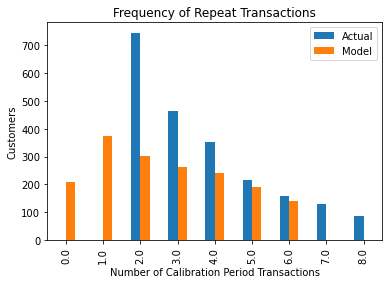

In [56]:
##############################################################
# Evaluation of Forecast Results
##############################################################

plt.figure(figsize = (15,5))
plot_period_transactions(bgf)
plt.show()

In [57]:
############################################################
# Establishing the GAMMA-GAMMA Model
############################################################

# We find the estimated average profit per transaction of a client...

# Conditonal expected average profit will be calculated...

ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(frequency= cltv_df["Frequence"],
        monetary_value=cltv_df["Monetary"])

<lifetimes.GammaGammaFitter: fitted with 2570 subjects, p: 3.82, q: 0.35, v: 3.75>

In [58]:
# Customers' estimated average expected profits...

ggf.conditional_expected_average_profit(frequency=cltv_df["Frequence"],
                                        monetary_value=cltv_df["Monetary"]).sort_values(ascending=False).head(10)

Customer ID
14088.000   3911.319
18102.000   3595.193
14096.000   3191.387
17511.000   2938.274
15749.000   2675.119
17450.000   2639.419
13081.000   2616.624
16984.000   2452.125
16000.000   2181.324
16684.000   2133.204
dtype: float64

In [59]:
# By looking at the results, we see that the frequency alone is not enough for its monetary value....

cltv_df["Excepted_Average_Profit"] = \
ggf.conditional_expected_average_profit(frequency=cltv_df["Frequence"],
                                        monetary_value=cltv_df["Monetary"])

In [60]:
cltv_df.sort_values("Excepted_Average_Profit", ascending = False).head(20)

,Recency,T,Frequence,Monetary,Excepted_Purc_1_Week,Excepted_Purc_1_Month,Excepted_Purc_4_Month,Excepted_Average_Profit
Customer ID,,,,,,,,
14088.000,44.571,46.143,13,3859.602,0.260,1.036,4.097,3911.319
18102.000,52.286,52.571,60,3584.888,0.965,3.851,15.250,3595.193
14096.000,13.857,14.571,17,3159.077,0.723,2.874,11.244,3191.387
17511.000,52.857,53.429,31,2921.952,0.507,2.024,8.016,2938.274
15749.000,13.857,47.571,3,2521.447,0.028,0.113,0.447,2675.119
17450.000,51.286,52.571,46,2629.530,0.745,2.972,11.771,2639.419
13081.000,51.286,53.143,11,2575.623,0.201,0.802,3.174,2616.624
16984.000,5.857,18.714,2,2240.675,0.103,0.411,1.608,2452.125
16000.000,0.000,0.429,3,2055.787,0.416,1.641,6.299,2181.324


In [61]:
"""
Parameters
----------
transaction_prediction_model: model
    the model to predict future transactions, literature uses
    pareto/ndb models but we can also use a different model like beta-geo models
frequency: array_like
    the frequency vector of customers' purchases
    (denoted x in literature).
recency: the recency vector of customers' purchases
         (denoted t_x in literature).
T: array_like
    customers' age (time units since first purchase)
monetary_value: array_like
    the monetary value vector of customer's purchases
    (denoted m in literature).
time: float, optional
    the lifetime expected for the user in months. Default: 12
discount_rate: float, optional
    the monthly adjusted discount rate. Default: 0.01
freq: string, optional
    {"D", "H", "M", "W"} for day, hour, month, week. This represents what unit of time your T is measure in.
    
"""

cltv_six_months=\
ggf.customer_lifetime_value(transaction_prediction_model=bgf,
                            frequency = cltv_df["Frequence"],
                            recency = cltv_df["Recency"],
                            T = cltv_df["T"],
                            monetary_value = cltv_df["Monetary"],
                            time = 6,# 6 Months 
                            freq="W", # T's frequency information. Weekly
                            discount_rate = 0.01 # Discount
                            ) 

In [62]:
cltv_six_months.head()

Customer ID
12747.000    1937.046
12748.000   12365.796
12749.000    3446.010
12820.000     631.939
12822.000    1612.097
Name: clv, dtype: float64

In [63]:
cltv_six_months.name = "Clv_Six_Months"
cltv_six_months = cltv_six_months.reset_index()
cltv_six_months.sort_values(by = "Clv_Six_Months", ascending=False).head(30)

,Customer ID,Clv_Six_Months
2486,18102.000,85651.010
589,14096.000,55650.647
2184,17450.000,48533.310
2213,17511.000,36797.007
1804,16684.000,25083.025
406,13694.000,25060.709
587,14088.000,25010.059
1173,15311.000,23591.389
133,13089.000,22927.693
1057,15061.000,21123.082


In [64]:
cltv_final = cltv_df.merge(cltv_six_months, on = "Customer ID", how = "left")
cltv_final.sort_values(by = "Clv_Six_Months" , ascending = False).head(10)

,Customer ID,Recency,T,Frequence,Monetary,Excepted_Purc_1_Week,Excepted_Purc_1_Month,Excepted_Purc_4_Month,Excepted_Average_Profit,Clv_Six_Months
2486,18102.000,52.286,52.571,60,3584.888,0.965,3.851,15.250,3595.193,85651.010
589,14096.000,13.857,14.571,17,3159.077,0.723,2.874,11.244,3191.387,55650.647
2184,17450.000,51.286,52.571,46,2629.530,0.745,2.972,11.771,2639.419,48533.310
2213,17511.000,52.857,53.429,31,2921.952,0.507,2.024,8.016,2938.274,36797.007
1804,16684.000,50.429,51.286,28,2120.047,0.477,1.901,7.528,2133.204,25083.025
406,13694.000,52.714,53.429,50,1267.363,0.798,3.185,12.613,1271.785,25060.709
587,14088.000,44.571,46.143,13,3859.602,0.260,1.036,4.097,3911.319,25010.059
1173,15311.000,53.286,53.429,91,667.597,1.429,5.699,22.574,668.894,23591.389
133,13089.000,52.286,52.857,97,605.187,1.532,6.112,24.205,606.294,22927.693
1057,15061.000,52.571,53.286,48,1108.308,0.769,3.069,12.155,1112.347,21123.082


In [65]:
print("CLTV Shape : {}".format(cltv_final.shape))

CLTV Shape : (2570, 10)


* Here, we can focus on the CustomerIDs of 14088 and 14096 in the notes that will interest us. Here, although they are new compared to others, they are close compared to the old ones they left, which means that there may be a relationship between Recency and T...

### Mission 2:

CLTV analysis consisting of different time periods

* Calculate 1-month and 12-month CLTV for 2010-2011 UK customers.

* Analyze the top 10 people at 1-month CLTV and the top 10 people at 12 months.

* Is there a difference? If so, why do you think it could be?

* CAUTION! There is no need to build a model from scratch. It is possible to proceed over the model created in the previous question.

In [66]:
# 1 month CLTV analysis

cltv_one_monthly = ggf.customer_lifetime_value(transaction_prediction_model= bgf,
                                               frequency= cltv_df["Frequence"],
                                               recency= cltv_df["Recency"],
                                               T=cltv_df["T"],
                                               monetary_value= cltv_df["Monetary"],
                                               time = 1,
                                               freq = "W",
                                               discount_rate=0.01)

In [67]:
cltv_one_monthly.head()

Customer ID
12747.000    336.779
12748.000   2148.376
12749.000    604.071
12820.000    110.125
12822.000    286.922
Name: clv, dtype: float64

In [68]:
cltv_one_monthly.name = "Clv_One_Month"
cltv_one_monthly = cltv_one_monthly.reset_index()

cltv_one_month = cltv_df.merge(cltv_one_monthly, on = "Customer ID", how = "left")
cltv_one_month.sort_values(by = "Clv_One_Month" , ascending= False).head(10)

,Customer ID,Recency,T,Frequence,Monetary,Excepted_Purc_1_Week,Excepted_Purc_1_Month,Excepted_Purc_4_Month,Excepted_Average_Profit,Clv_One_Month
2486,18102.000,52.286,52.571,60,3584.888,0.965,3.851,15.250,3595.193,14884.975
589,14096.000,13.857,14.571,17,3159.077,0.723,2.874,11.244,3191.387,9855.880
2184,17450.000,51.286,52.571,46,2629.530,0.745,2.972,11.771,2639.419,8434.765
2213,17511.000,52.857,53.429,31,2921.952,0.507,2.024,8.016,2938.274,6394.324
1804,16684.000,50.429,51.286,28,2120.047,0.477,1.901,7.528,2133.204,4361.054
587,14088.000,44.571,46.143,13,3859.602,0.260,1.036,4.097,3911.319,4355.485
406,13694.000,52.714,53.429,50,1267.363,0.798,3.185,12.613,1271.785,4354.469
1173,15311.000,53.286,53.429,91,667.597,1.429,5.699,22.574,668.894,4098.869
133,13089.000,52.286,52.857,97,605.187,1.532,6.112,24.205,606.294,3984.052
1485,16000.000,0.000,0.429,3,2055.787,0.416,1.641,6.299,2181.324,3843.979


In [69]:
# 12 months CLTV analysis

cltv_twelve_monthly = ggf.customer_lifetime_value(transaction_prediction_model= bgf,
                                                  frequency=cltv_df["Frequence"],
                                                  recency=cltv_df["Recency"],
                                                  T=cltv_df["T"],
                                                  monetary_value=cltv_df["Monetary"],
                                                  time = 12,
                                                  freq="W",
                                                  discount_rate = 0.01)

In [70]:
cltv_twelve_monthly.head()

Customer ID
12747.000    3698.381
12748.000   23623.997
12749.000    6538.828
12820.000    1204.326
12822.000    3029.795
Name: clv, dtype: float64

In [71]:
cltv_twelve_monthly.name = "Clv_Twelve_Months"
cltv_twelve_monthly = cltv_twelve_monthly.reset_index()

cltv_twelve_month = cltv_df.merge(cltv_twelve_monthly, on = "Customer ID", how = "left")
cltv_twelve_month.sort_values(by = "Clv_Twelve_Months", ascending = False).head(10)

,Customer ID,Recency,T,Frequence,Monetary,Excepted_Purc_1_Week,Excepted_Purc_1_Month,Excepted_Purc_4_Month,Excepted_Average_Profit,Clv_Twelve_Months
2486,18102.000,52.286,52.571,60,3584.888,0.965,3.851,15.250,3595.193,163591.127
589,14096.000,13.857,14.571,17,3159.077,0.723,2.874,11.244,3191.387,104900.443
2184,17450.000,51.286,52.571,46,2629.530,0.745,2.972,11.771,2639.419,92694.275
2213,17511.000,52.857,53.429,31,2921.952,0.507,2.024,8.016,2938.274,70285.652
1804,16684.000,50.429,51.286,28,2120.047,0.477,1.901,7.528,2133.204,47890.364
406,13694.000,52.714,53.429,50,1267.363,0.798,3.185,12.613,1271.785,47871.900
587,14088.000,44.571,46.143,13,3859.602,0.260,1.036,4.097,3911.319,47688.864
1173,15311.000,53.286,53.429,91,667.597,1.429,5.699,22.574,668.894,45067.809
133,13089.000,52.286,52.857,97,605.187,1.532,6.112,24.205,606.294,43795.473
1057,15061.000,52.571,53.286,48,1108.308,0.769,3.069,12.155,1112.347,40348.817


In [72]:
cltv_one_month.sort_values(by = "Clv_One_Month", ascending = False).head(10)

,Customer ID,Recency,T,Frequence,Monetary,Excepted_Purc_1_Week,Excepted_Purc_1_Month,Excepted_Purc_4_Month,Excepted_Average_Profit,Clv_One_Month
2486,18102.000,52.286,52.571,60,3584.888,0.965,3.851,15.250,3595.193,14884.975
589,14096.000,13.857,14.571,17,3159.077,0.723,2.874,11.244,3191.387,9855.880
2184,17450.000,51.286,52.571,46,2629.530,0.745,2.972,11.771,2639.419,8434.765
2213,17511.000,52.857,53.429,31,2921.952,0.507,2.024,8.016,2938.274,6394.324
1804,16684.000,50.429,51.286,28,2120.047,0.477,1.901,7.528,2133.204,4361.054
587,14088.000,44.571,46.143,13,3859.602,0.260,1.036,4.097,3911.319,4355.485
406,13694.000,52.714,53.429,50,1267.363,0.798,3.185,12.613,1271.785,4354.469
1173,15311.000,53.286,53.429,91,667.597,1.429,5.699,22.574,668.894,4098.869
133,13089.000,52.286,52.857,97,605.187,1.532,6.112,24.205,606.294,3984.052
1485,16000.000,0.000,0.429,3,2055.787,0.416,1.641,6.299,2181.324,3843.979


* CustomerId's came same. Except CustomerID at 12 months!!! If we look at the observations in the 10th place between 12 months and 1 month, two things may have happened here, either the customer in 1 month may have become churn or the parameters are not enough for our interpretation...


* When we look at the 2nd and 6th rows, rather than the low frequency values, the amount of clv they have left is quite high compared to the others... There may be a relationship between the Recency and T variables.


* The 1-month forecast and the 12-month CLV values were different, but this is quite normal, since the period increases on a monthly basis, the values are a little higher at 12 months. There is no difference between the two.

### Mission 3:

#### Segmentation and Action Recommendations

* For 2010-2011 UK customers, divide all your customers into 4 groups (segments) according to 6-month CLTV and add the group names to the dataset.


* Make short 6-month action suggestions to the management for 2 groups you will choose from among 4 groups.

In [73]:
# Standardization of CLTV

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
cltv_final["Scaled_Clv_Six_Months"] = scaler.fit_transform(cltv_final[["Clv_Six_Months"]])

In [74]:
cltv_final.sort_values(by = "Clv_Six_Months", ascending = False).head()

,Customer ID,Recency,T,Frequence,Monetary,Excepted_Purc_1_Week,Excepted_Purc_1_Month,Excepted_Purc_4_Month,Excepted_Average_Profit,Clv_Six_Months,Scaled_Clv_Six_Months
2486,18102.000,52.286,52.571,60,3584.888,0.965,3.851,15.250,3595.193,85651.010,1.000
589,14096.000,13.857,14.571,17,3159.077,0.723,2.874,11.244,3191.387,55650.647,0.650
2184,17450.000,51.286,52.571,46,2629.530,0.745,2.972,11.771,2639.419,48533.310,0.567
2213,17511.000,52.857,53.429,31,2921.952,0.507,2.024,8.016,2938.274,36797.007,0.430
1804,16684.000,50.429,51.286,28,2120.047,0.477,1.901,7.528,2133.204,25083.025,0.293


In [75]:
############################################################
# Creation of Segments by 6 Months CLTV
############################################################

cltv_final["Segment"] = pd.qcut(cltv_final["Scaled_Clv_Six_Months"], 4 , labels = ["D","C","B","A"])

cltv_final.head()

,Customer ID,Recency,T,Frequence,Monetary,Excepted_Purc_1_Week,Excepted_Purc_1_Month,Excepted_Purc_4_Month,Excepted_Average_Profit,Clv_Six_Months,Scaled_Clv_Six_Months,Segment
0,12747.000,52.286,52.857,11,381.455,0.202,0.808,3.198,387.823,1937.046,0.023,A
1,12748.000,53.143,53.429,210,153.828,3.253,12.978,51.403,153.971,12365.796,0.144,A
2,12749.000,29.857,30.571,5,814.488,0.167,0.666,2.622,844.095,3446.010,0.040,A
3,12820.000,46.143,46.714,4,235.585,0.104,0.415,1.639,247.081,631.939,0.007,C
4,12822.000,2.286,12.571,2,474.440,0.129,0.513,1.999,520.828,1612.097,0.019,B


In [77]:
cltv_final.iloc[:,1:].groupby("Segment").agg({"mean","sum"})

Recency                T        Frequence          Monetary         Excepted_Purc_1_Week       Excepted_Purc_1_Month       Excepted_Purc_4_Month       Excepted_Average_Profit          \
              sum   mean       sum   mean       sum   mean        sum    mean                  sum  mean                   sum  mean                   sum  mean                     sum    mean   
Segment                                                                                                                                                                                            
D       14189.143 22.067 26047.286 40.509      1973  3.068 114084.271 177.425               45.664 0.071               181.873 0.283               716.565 1.114              123598.078 192.221   
C       19797.000 30.836 24502.286 38.166      2562  3.991 167362.508 260.689               76.725 0.120               305.542 0.476              1203.361 1.874              178520.781 278.070   
B       19156.571 29.839 22545.143 35.117      3502  5.455 225975.561 351.987              103.631 0.161               412.484 0.642              1622.250 2.527              237858.161 370.496   
A       20229.143 31.461 22195.857 34.519      7261 11.292 376992.323 586.302              175.162 0.272               697.374 1.085              2745.115 4.269              391391.925 608.697   

        Clv_Six_Months          Scaled_Clv_Six_Months        
                   sum     mean                   sum  mean  
Segment                                                      
D           173267.312  269.467                 2.023 0.003  
C           456348.818  710.824                 5.328 0.008  
B           816208.559 1271.353                 9.529 0.015  
A          2447482.389 3806.349                28.575 0.044

* The frequency value and monetary value of the A segment are high. It has a young audience according to segments.

* We can apply campaigns in the B segment to increase it to the A segment. They can earn us more income.

* We can separate the D and C segments as a group. As a result, although they are low in return and frequency, they may have a potential for us in the future, although they are older than others in terms of recency and T values. Campaigns can be organized within them, they can be small-scale. Keeping in touch with them always opens a door of profit for us...

### Mission 4:

### Sending records to database

* Send the final table, which will consist of the following variables, to the database.

* Create the name of the table as name_surname.

* The table name must be entered in the "name" section of the relevant function.

In [78]:
cltv_final["Customer ID"] = cltv_final["Customer ID"].astype(int)

#cltv_final.to_sql(name = "Gokhan_Ersoz", con = con, if_exists="replace", index = False)

pd.read_sql_query("show tables", conn)


,Tables_in_synan_dsmlbc_group_3
0,CLTV_Prediction_Tugce_Ljungholm
1,cagatay_tuylu_cltv_final
2,cltv-prediction-selime
3,cltv_burak_aslan
4,cltv_prediction
5,cltv_prediction_Burcu_Unluturk
6,cltv_prediction_ErenPAMUKCU
7,cltv_prediction_Kamran_Aliyev
8,cltv_prediction_M_Ahmetcan_Yalcin
9,cltv_prediction_ali
